In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from pixelator import read_pna as read
from pixelator.pna.plot import molecule_rank_plot

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
import pandas as pd
from pixelator.common.statistics import clr_transformation, dsb_normalize
import scanpy as sc
from pixelator.mpx.plot import density_scatter_plot
import scanpy.external as sce
import networkx as nx

from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import NearestNeighbors
from scipy.stats import norm
from pixelator.common.statistics import clr_transformation, dsb_normalize

from pixelator.pna.analysis import calculate_differential_proximity
from rich import print
import anndata as ad
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
from statsmodels.stats.multitest import multipletests

import sys
sys.path.append('/home/projects/nyosef/zvise/PixelGen/PixelGen')

from multimodalvi import MultiModalSCVI
from multimodalvae import MultiModalVAE, AggMethod, D
from enums import AggMethod, D
from metrics import MultiModalVIMetrics
from sklearn.preprocessing import PowerTransformer
from pxl_utils import train_model, get_model_latents, convert_polarization_to_feature_matrix, \
     convert_colocalization_to_feature_matrix, download_pxl
from scvi_utils import plot_losses, pca_neighbors_umap, calc_PCA, add_one_hot_encoding_obsm, plot_cumulative_variance
from common_utils import standardize, std_clip, filter_hv, split_pair_column, filter_df_by_two_columns, rank_plot
from metrics import MultiModalVIMetrics, distr_autocorrelation_in_latent
from multimodalvi import MultiModalSCVI
from multimodalvae import MultiModalVAE, AggMethod, D
from enums import AggMethod, D
from scvi.model import SCVI

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# SETUP

In [3]:
ADATA_FOR_MODEL_PATH='/home/projects/nyosef/zvise/PixelGen/PixelGen/Data/adatas/PBMC_adata_for_model.h5ad'
adata=sc.read_h5ad(ADATA_FOR_MODEL_PATH)
adata.layers["arcsinh"] = np.arcsinh(adata.X / 5)

In [4]:
adata=adata[adata.obs.condition=='unstim'].copy()
adata

AnnData object with n_obs × n_vars = 1078 × 158
    obs: 'n_umi1', 'n_umi2', 'n_edges', 'reads_in_component', 'n_antibodies', 'n_umi', 'isotype_fraction', 'intracellular_fraction', 'tau_type', 'tau', 'disqualified_for_denoising', 'number_of_nodes_removed_in_denoise', 'sample', 'antibodies', 'average_k_core', 'k_core_1', 'k_core_2', 'k_core_3', 'k_core_4', 'svd_var_expl_s1', 'svd_var_expl_s2', 'svd_var_expl_s3', 'condition', 'total_counts', 'leiden', 'cell_type'
    var: 'antibody_count', 'antibody_pct', 'components', 'control', 'nuclear', 'detection_rate', 'whitelisted', 'keep_protein'
    uns: 'cell_type_colors', 'condition_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'clr', 'log1p', 'spatial_arcsinh', 'spatial_arcsinh_2000', 'spatial_id'
    varm: 'PCs'
    layers: 'counts', 'log1p', 'norm_log1p', 'arcsinh'
    obsp: 'connectivities', 'distances'

In [12]:
adata.obs["t_cell"] = adata.obs["cell_type"].astype(str).str.startswith("CD")
t_cell_adata=adata[adata.obs["t_cell"]==True].copy()
t_cell_adata

AnnData object with n_obs × n_vars = 549 × 158
    obs: 'n_umi1', 'n_umi2', 'n_edges', 'reads_in_component', 'n_antibodies', 'n_umi', 'isotype_fraction', 'intracellular_fraction', 'tau_type', 'tau', 'disqualified_for_denoising', 'number_of_nodes_removed_in_denoise', 'sample', 'antibodies', 'average_k_core', 'k_core_1', 'k_core_2', 'k_core_3', 'k_core_4', 'svd_var_expl_s1', 'svd_var_expl_s2', 'svd_var_expl_s3', 'condition', 'total_counts', 'leiden', 'cell_type', 't_cell'
    var: 'antibody_count', 'antibody_pct', 'components', 'control', 'nuclear', 'detection_rate', 'whitelisted', 'keep_protein'
    uns: 'cell_type_colors', 'condition_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap', 'clr', 'log1p', 'spatial_arcsinh', 'spatial_arcsinh_2000', 'spatial_id'
    varm: 'PCs'
    layers: 'counts', 'log1p', 'norm_log1p', 'arcsinh'
    obsp: 'connectivities', 'distances'

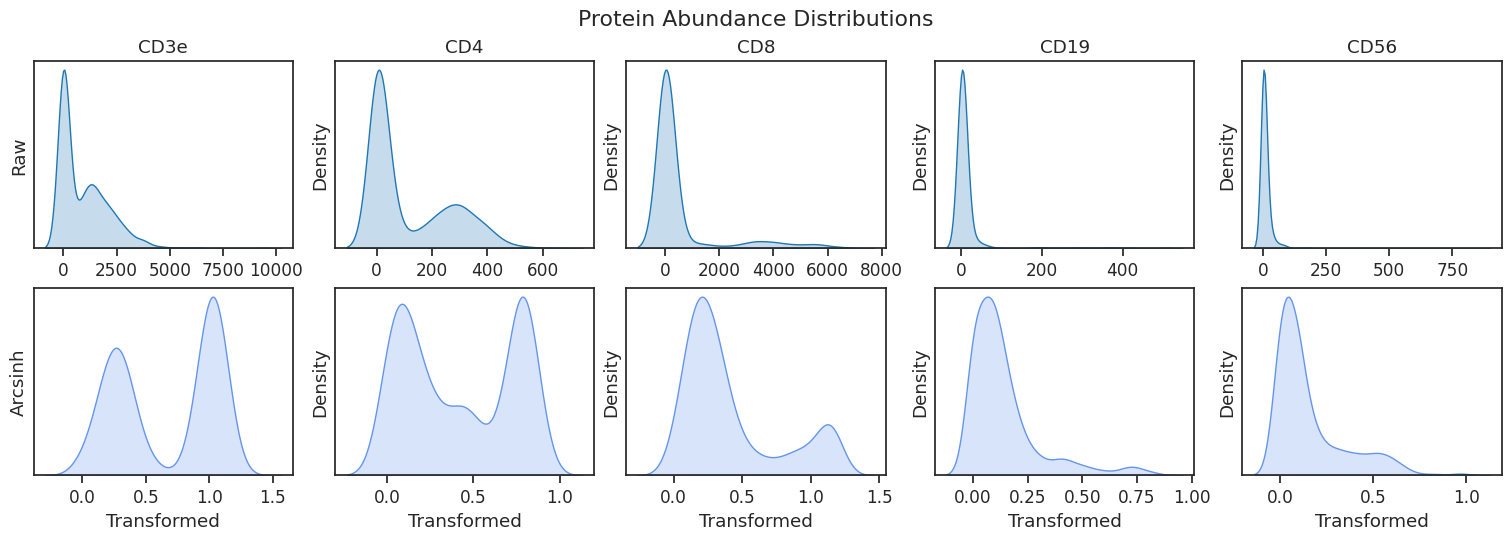

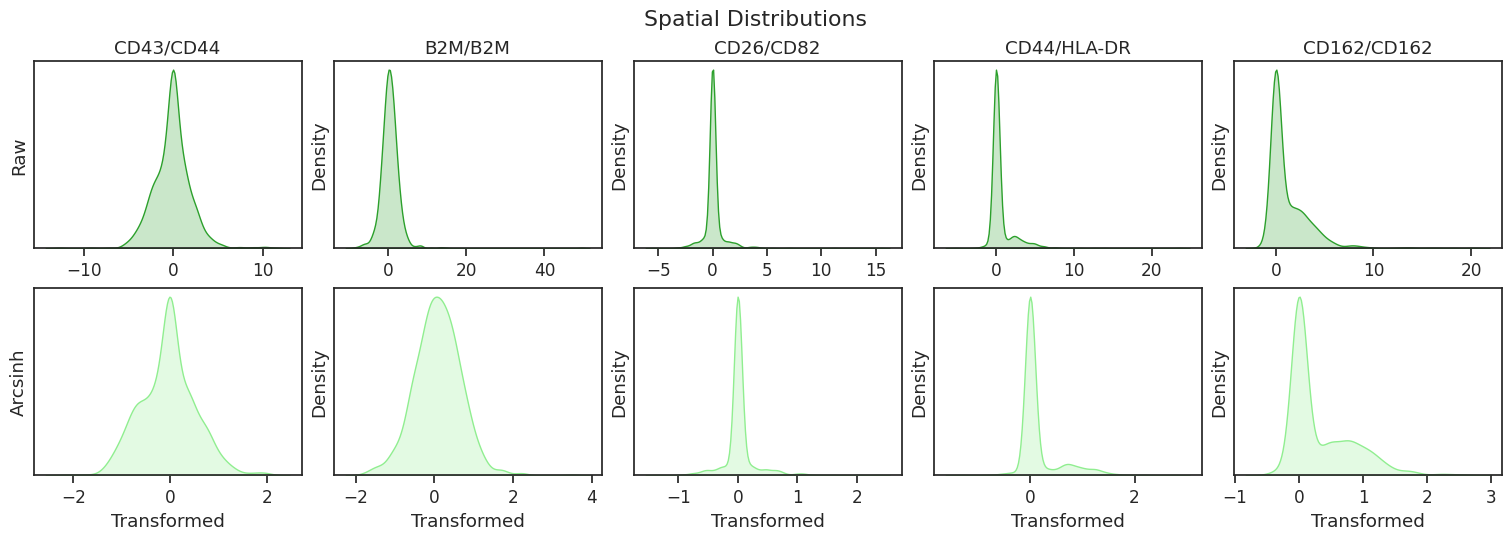

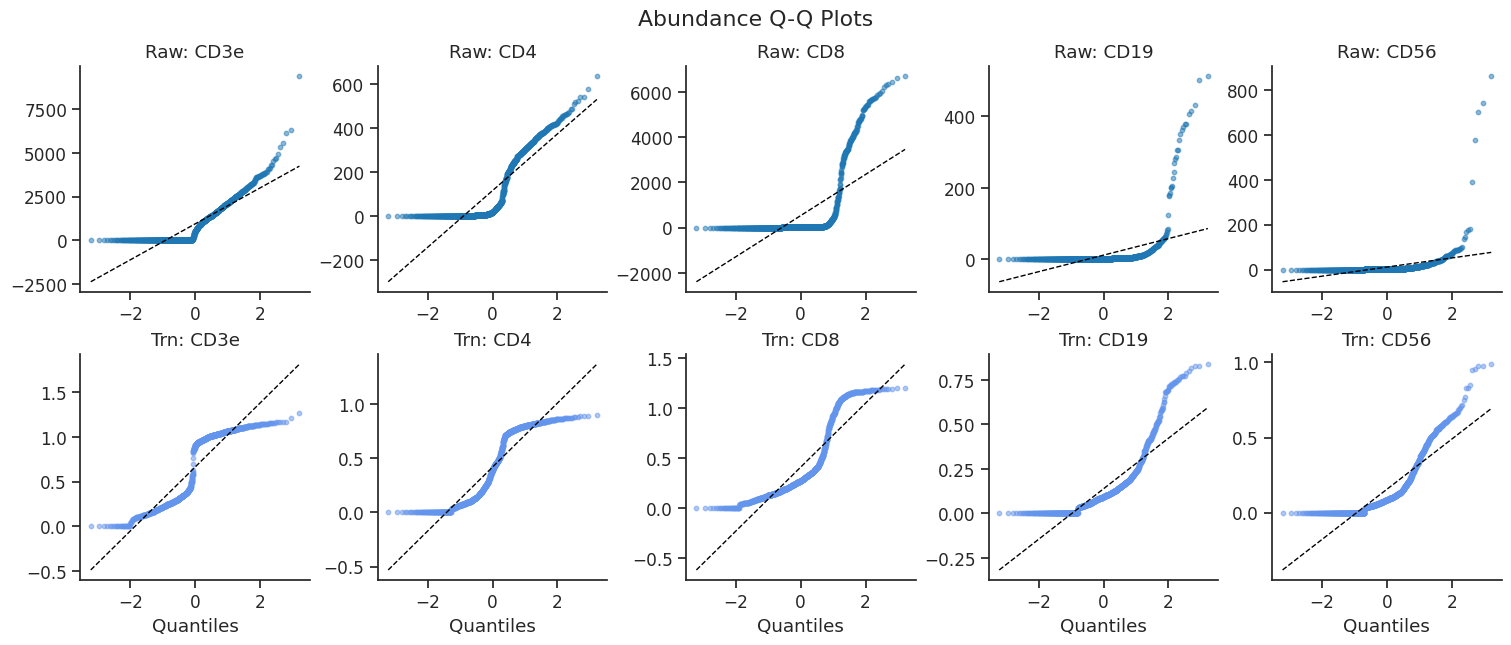

In [31]:
# Setup & Data Extraction
sns.set_style("ticks")
markers = ['CD3e','CD4','CD8','CD19','CD56']
sp_feats = ['CD43/CD44','B2M/B2M','CD26/CD82','CD44/HLA-DR','CD162/CD162']
def get_data(src, cols): return pd.DataFrame(getattr(src, "toarray", lambda: src)(), columns=cols)

ab_raw = get_data(adata[:, markers].layers['counts'], markers)
ab_trn = get_data(adata[:, markers].layers['arcsinh'], markers)
sp_raw = adata.obsm['spatial_id'][sp_feats]
sp_trn = adata.obsm['spatial_arcsinh'][sp_feats]

# 1. Abundance Distributions (Blue)
fig1, ax1 = plt.subplots(2, 5, figsize=(15, 5), constrained_layout=True)
for i, m in enumerate(markers):
    sns.kdeplot(ab_raw[m], ax=ax1[0, i], fill=True, color="tab:blue")
    sns.kdeplot(ab_trn[m], ax=ax1[1, i], fill=True, color="cornflowerblue")
    ax1[0, i].set(title=m, xlabel="", yticks=[]); ax1[1, i].set(xlabel="Transformed", yticks=[])
    if i==0: ax1[0,0].set_ylabel("Raw"); ax1[1,0].set_ylabel("Arcsinh")
fig1.suptitle("Protein Abundance Distributions", y=1.05)

# 2. Spatial Distributions (Green)
fig2, ax2 = plt.subplots(2, 5, figsize=(15, 5), constrained_layout=True)
for i, f in enumerate(sp_feats):
    sns.kdeplot(sp_raw[f], ax=ax2[0, i], fill=True, color="tab:green")
    sns.kdeplot(sp_trn[f], ax=ax2[1, i], fill=True, color="lightgreen")
    ax2[0, i].set(title=f, xlabel="", yticks=[]); ax2[1, i].set(xlabel="Transformed", yticks=[])
    if i==0: ax2[0,0].set_ylabel("Raw"); ax2[1,0].set_ylabel("Arcsinh")
fig2.suptitle("Spatial Distributions", y=1.05)

# 3. Abundance Q-Q Plots (Independent)
fig3, ax3 = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
for i, m in enumerate(markers):
    for row, data, c, lbl in [(0, ab_raw[m], "tab:blue", "Raw"), (1, ab_trn[m], "cornflowerblue", "Trn")]:
        (osm, osr), (slope, intc, _) = stats.probplot(data.dropna(), dist="norm", plot=None)
        ax3[row, i].scatter(osm, osr, color=c, alpha=0.5, s=10)
        ax3[row, i].plot(osm, slope*osm + intc, "k--", lw=1)
        ax3[row, i].set(title=f"{lbl}: {m}", xlabel="Quantiles" if row==1 else "")
        sns.despine(ax=ax3[row, i])
fig3.suptitle("Abundance Q-Q Plots", y=1.05)

plt.show()

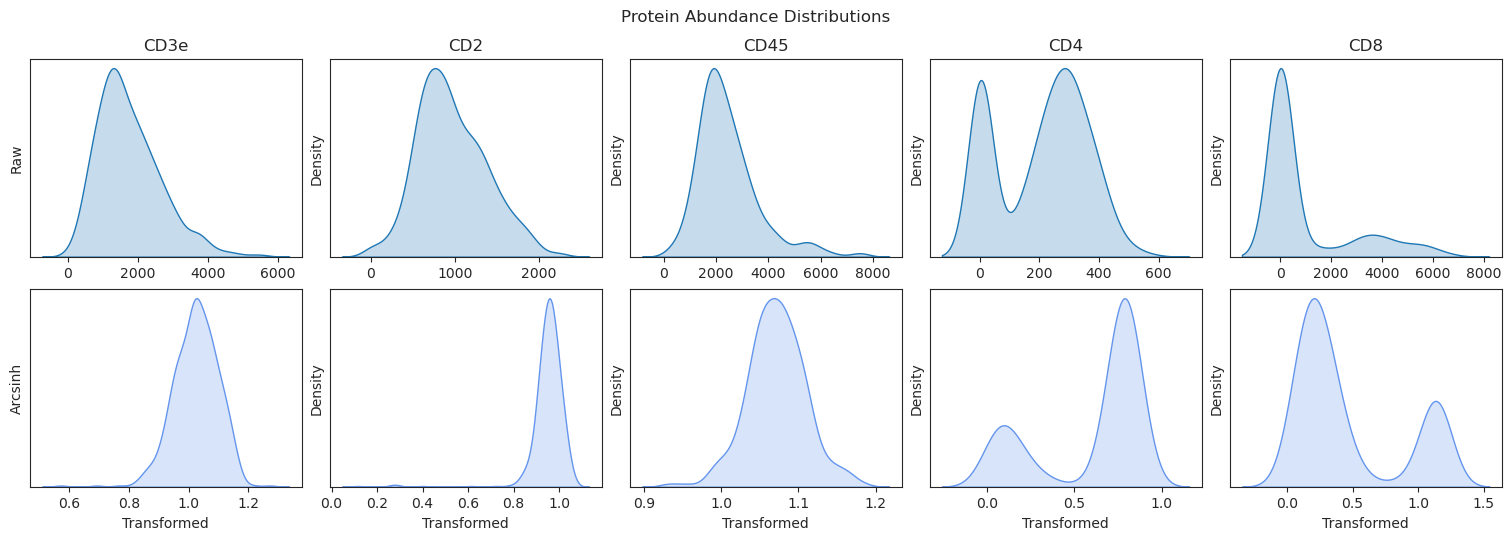

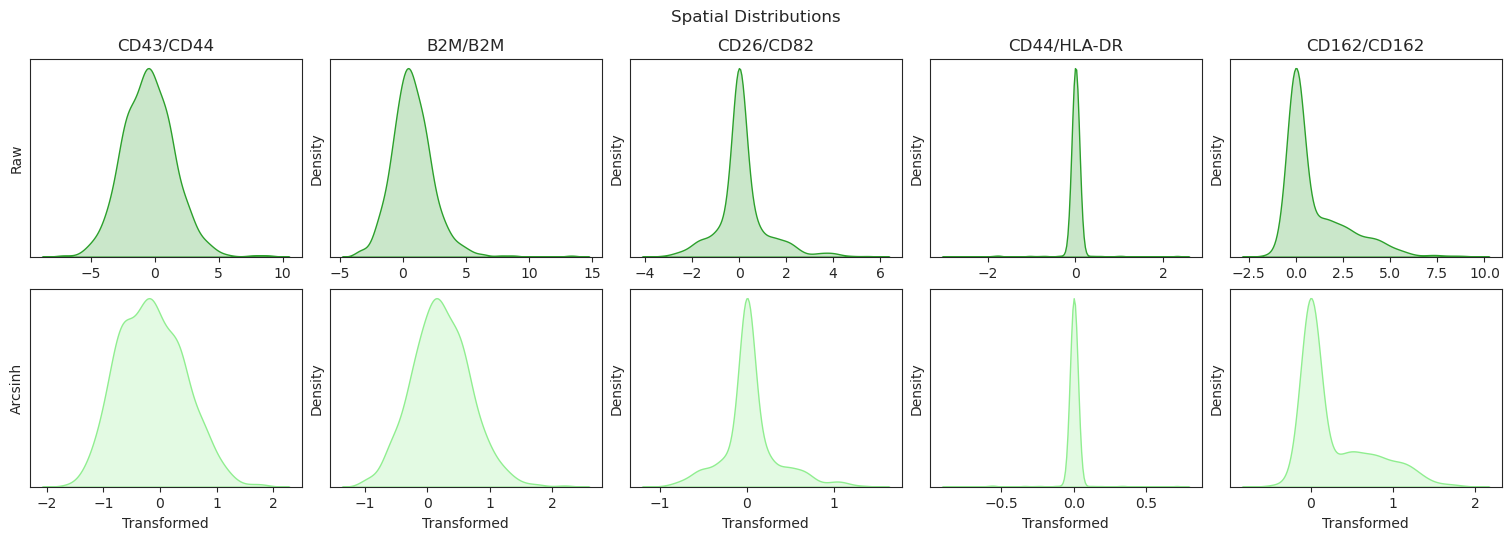

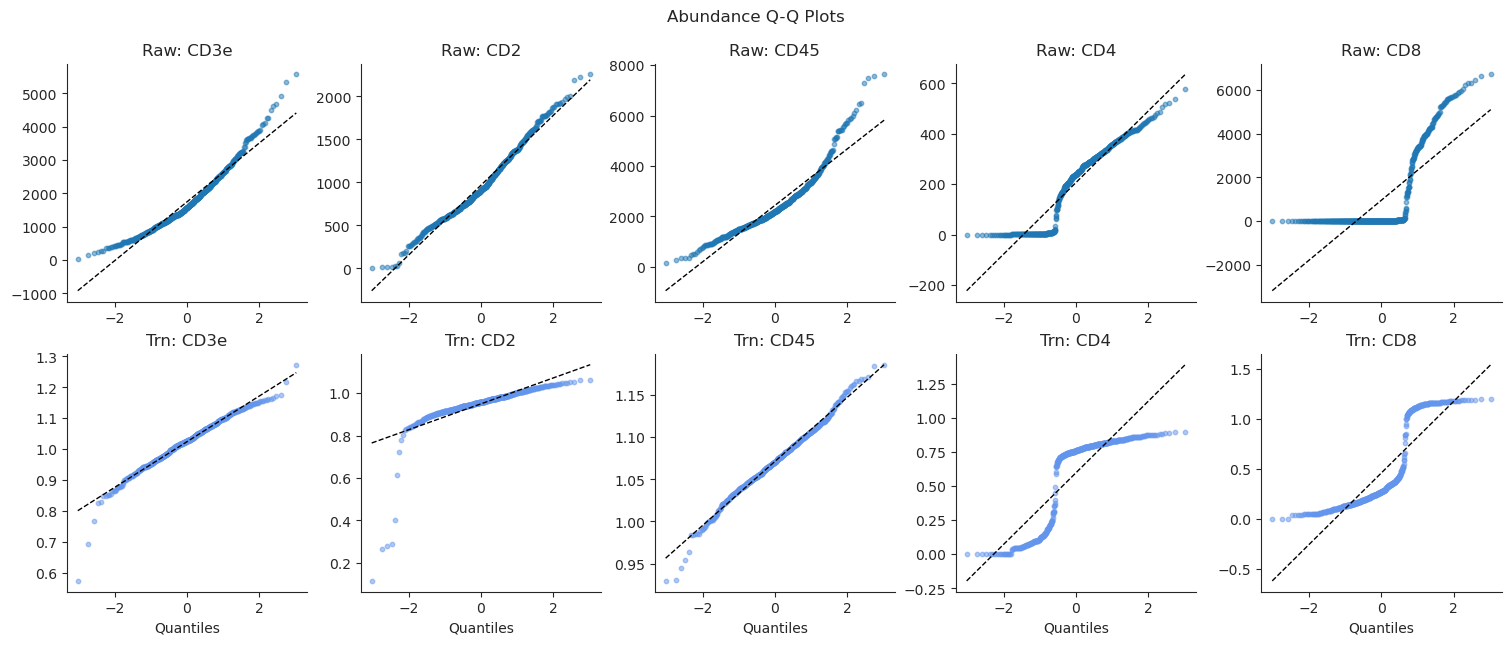

In [17]:
# Setup & Data Extraction
sns.set_style("ticks")
markers = ['CD3e','CD2','CD45','CD4','CD8']
sp_feats = ['CD43/CD44','B2M/B2M','CD26/CD82','CD44/HLA-DR','CD162/CD162']
def get_data(src, cols): return pd.DataFrame(getattr(src, "toarray", lambda: src)(), columns=cols)

ab_raw = get_data(t_cell_adata[:, markers].layers['counts'], markers)
ab_trn = get_data(t_cell_adata[:, markers].layers['arcsinh'], markers)
sp_raw = t_cell_adata.obsm['spatial_id'][sp_feats]
sp_trn = t_cell_adata.obsm['spatial_arcsinh'][sp_feats]

# 1. Abundance Distributions (Blue)
fig1, ax1 = plt.subplots(2, 5, figsize=(15, 5), constrained_layout=True)
for i, m in enumerate(markers):
    sns.kdeplot(ab_raw[m], ax=ax1[0, i], fill=True, color="tab:blue")
    sns.kdeplot(ab_trn[m], ax=ax1[1, i], fill=True, color="cornflowerblue")
    ax1[0, i].set(title=m, xlabel="", yticks=[]); ax1[1, i].set(xlabel="Transformed", yticks=[])
    if i==0: ax1[0,0].set_ylabel("Raw"); ax1[1,0].set_ylabel("Arcsinh")
fig1.suptitle("Protein Abundance Distributions", y=1.05)

# 2. Spatial Distributions (Green)
fig2, ax2 = plt.subplots(2, 5, figsize=(15, 5), constrained_layout=True)
for i, f in enumerate(sp_feats):
    sns.kdeplot(sp_raw[f], ax=ax2[0, i], fill=True, color="tab:green")
    sns.kdeplot(sp_trn[f], ax=ax2[1, i], fill=True, color="lightgreen")
    ax2[0, i].set(title=f, xlabel="", yticks=[]); ax2[1, i].set(xlabel="Transformed", yticks=[])
    if i==0: ax2[0,0].set_ylabel("Raw"); ax2[1,0].set_ylabel("Arcsinh")
fig2.suptitle("Spatial Distributions", y=1.05)

# 3. Abundance Q-Q Plots (Independent)
fig3, ax3 = plt.subplots(2, 5, figsize=(15, 6), constrained_layout=True)
for i, m in enumerate(markers):
    for row, data, c, lbl in [(0, ab_raw[m], "tab:blue", "Raw"), (1, ab_trn[m], "cornflowerblue", "Trn")]:
        (osm, osr), (slope, intc, _) = stats.probplot(data.dropna(), dist="norm", plot=None)
        ax3[row, i].scatter(osm, osr, color=c, alpha=0.5, s=10)
        ax3[row, i].plot(osm, slope*osm + intc, "k--", lw=1)
        ax3[row, i].set(title=f"{lbl}: {m}", xlabel="Quantiles" if row==1 else "")
        sns.despine(ax=ax3[row, i])
fig3.suptitle("Abundance Q-Q Plots", y=1.05)

plt.show()